In [1]:
import tensorflow as tf
import edward as ed
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
class Gumbel:
    def __init__(self, shape, logits, name='Gumbel'):
        self.shape = shape
        self.name = name
        self.logits = logits - tf.log(tf.reduce_sum(tf.exp(logits), axis=-1))[...,tf.newaxis]
    def sample(self, us=None, argmax=None):
        with tf.name_scope(self.name):
            if us is None:
                us = tf.random_uniform(self.shape, minval=1e-3, maxval=1-1e-3)
            self.uniform_sample = us
            
            if argmax is None:
                gb = -tf.log(-tf.log(us)) + self.logits
            else:
                upper = -tf.log(-tf.log(us))
                argmax_ix = tf.argmax(argmax, axis=-1)
                upper_samples = tf.reduce_sum(us*argmax, axis=-1)
                gb = -tf.log(-tf.log(us)/tf.exp(self.logits) - tf.log(upper_samples)[...,tf.newaxis])
                gb = upper*argmax + gb*(1-argmax)
#                 return upper*argmax
            return gb

In [3]:
# gmb = Gumbel([10000,3], logits=np.array([[1,2,3]], dtype='float32'))

In [4]:
# ord_sample = gmb.sample()
# bnr = np.array([[0,1,0]]*10000, dtype='float32')
# cond_sample = gmb.sample(argmax=bnr)

In [5]:
# ord_sample = ord_sample.eval()
# cond_sample = cond_sample.eval()

In [6]:
# cond_sample_real = ord_sample[np.argmax(ord_sample, axis=-1) == 1]

In [7]:
# sns.kdeplot(cond_sample_real[:,0])
# plt.plot()

In [8]:
# sns.kdeplot(cond_sample[:,0])
# plt.plot()

In [9]:
# sess = tf.InteractiveSession()

In [10]:
# x = tf.Variable(1.)
# t = tf.Variable(1.)

# stoped_g_i = x - t
# stoped_g = tf.stop_gradient(stoped_g_i)
# loss = tf.square(tf.square(x - stoped_g_i))

In [11]:
# x_g = tf.gradients(loss, [x], stop_gradients=stoped_g_i)[0]

In [12]:
# t_g = tf.gradients(x_g, t, [t])

In [13]:
# tf.global_variables_initializer().run()

In [14]:
# t_g

In [15]:
# t_g[0].eval()

In [16]:
# x_g.eval()

In [17]:
# 4*(x-x+t)

In [18]:
X, y = make_moons(30000, noise=0.2)
X = X.astype('float32')
y = y.astype('float32')

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [20]:
dataset = dataset.shuffle(1000).repeat().batch(100)

In [21]:
diter = dataset.make_one_shot_iterator()

In [22]:
def dense(x, dim, name, activation=tf.nn.tanh):
    with tf.variable_scope(name, initializer=tf.random_normal_initializer(stddev=0.01)):
        W = tf.get_variable('W', [x.shape[1], dim])
        b = tf.get_variable('b', [1,dim])
        logit = tf.matmul(x, W) + b
        return activation(logit)
    
class VAE:
    def __init__(self, dim, hdim, temp, name='VAE', config=[128,64,32]):
        self.dim = dim
        self.hdim = hdim
        self.name = name
        self.config = config
        self.temp = temp
        with tf.variable_scope(self.name) as scope:
            self.scope = scope
    
    def priorkl(self, encoded, encoded_logits):
        with tf.name_scope('priorkl'):
            labels = tf.ones_like(encoded)/tf.cast(2, tf.float32)
            xent = tf.reduce_sum(encoded*tf.log(labels), axis=[-1,-2], name='xent')
#             nent = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=encoded, logits=encoded_logits)
#             nent = tf.reduce_sum(nent, axis=-1)
            nent = tf.reduce_sum(encoded*tf.log(encoded), axis=[-1,-2], name='nent')
            with tf.control_dependencies([tf.check_numerics(x, message='priorkl_numerics_{}'.format(x.name)) for x in [xent, nent]]):
                loss = -xent + nent
        return loss
            
    def encode(self, x, hard=False, uniform_sample=None, condition=None):
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE) as scope:
            self.encoder_scope = scope
            for i, out_dim in enumerate(self.config):
                x = dense(x, out_dim, name='d{}'.format(i))
                
            with tf.variable_scope('latent_inf'):
                logits = dense(x, self.hdim*2, name='logits', activation=lambda x: x)
                logits = tf.reshape(logits, [tf.shape(x)[0], self.hdim, 2])
                self.logits = logits
                
                self.center_loss = tf.reduce_mean(tf.square(tf.log(tf.reduce_sum(tf.exp(logits), axis=-1))))
                
                gd = Gumbel(tf.shape(logits), logits=logits)
                encoded_gumb = gd.sample(us=uniform_sample, argmax=condition)
                self.uniform_sample = gd.uniform_sample
                
                encoded = tf.nn.softmax(encoded_gumb/self.temp)
                self.kl_loss = self.priorkl(tf.nn.softmax(self.logits), self.logits)
                encoded_soft = encoded

                encoded_hard = tf.distributions.Multinomial(1., logits=self.logits).sample()
                
                return encoded_soft, encoded_hard
    
    def decode(self, x):
        with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE) as scope:
            self.decoder_scope = scope
            x = tf.reshape(x, [tf.shape(x)[0], self.hdim*2])
            for i, out_dim in enumerate(self.config[::-1]):
                x = dense(x, out_dim, name='d{}'.format(i))
            x = dense(x, self.dim, name='restoration', activation=lambda x: x)
            return x

In [23]:
data, y = diter.get_next()#tf.Variable(X, trainable=False)

In [24]:
with tf.variable_scope('ConVar'):
    pretemperature = tf.get_variable('pretemperature', shape=[1,16,2],
                                     initializer=tf.constant_initializer(math.log(.3)), trainable=False)
    preeta = tf.get_variable('peeta', shape=(),
                             initializer=tf.constant_initializer(0.), trainable=False)
    with tf.variable_scope('nvil_baseline') as nvil_scope:
        d1 = dense(data, 128, 'd1')
        nvil_baseline = dense(data, 1, 'out')[:,0]
    
    temperature = tf.exp(pretemperature)
    tf.summary.histogram('temperature', temperature)
    eta = tf.exp(preeta)

vae = VAE(2, 16, temp=temperature, config=[128,128,128])

In [25]:
_, encoded_hard = vae.encode(data)
encoded_soft, _ = vae.encode(data)
encoded_soft_conditioned, _ = vae.encode(data, condition=encoded_hard)

In [26]:
vae.logits

<tf.Tensor 'encoder_2/latent_inf/Reshape:0' shape=(?, 16, 2) dtype=float32>

In [27]:
sample_logp = tf.distributions.Multinomial(1., logits=vae.logits).log_prob(encoded_hard)
sample_logp = tf.reduce_sum(sample_logp, axis=-1)

In [28]:
decoded_soft = vae.decode(encoded_soft)
decoded_hard = vae.decode(encoded_hard)
decoded_soft_conditioned = vae.decode(encoded_soft_conditioned)

In [29]:
def rec_loss(x, dec):
    sigma = tf.constant(0.6)
    loss = tf.reduce_sum(tf.square(x - dec), axis=-1)/(2*tf.square(sigma)) - tf.log(2*3.14*sigma)
    return loss
def get_elbo(decoded):
    loss = rec_loss(data, decoded) + vae.kl_loss
    return -loss

In [30]:
soft_elbo = get_elbo(decoded_soft)
hard_elbo = get_elbo(decoded_hard)
soft_elbo_conditioned = get_elbo(decoded_soft_conditioned)

In [31]:
soft_elbo

<tf.Tensor 'Neg:0' shape=(?,) dtype=float32>

In [32]:
tf.summary.scalar('soft_elbo', tf.reduce_mean(soft_elbo))
tf.summary.scalar('hard_elbo', tf.reduce_mean(hard_elbo))

<tf.Tensor 'hard_elbo:0' shape=() dtype=string>

In [33]:
tf.summary.scalar('eta', eta)
tf.summary.scalar('mean_temperature', tf.reduce_mean(temperature))

<tf.Tensor 'mean_temperature:0' shape=() dtype=string>

In [34]:
graph = tf.get_default_graph()
encoder_vars = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=vae.encoder_scope.name)

In [35]:
# stoped_grad_input = hard_elbo - eta*soft_elbo_conditioned
stoped_grad = hard_elbo - eta*soft_elbo_conditioned - nvil_baseline
# stoped_grad = tf.stop_gradient(hard_elbo - eta*soft_elbo_conditioned)

target = -sample_logp*stoped_grad - eta*soft_elbo + eta*soft_elbo_conditioned + vae.center_loss
# mean_elbo = tf.Variable(-40.)
# tf.summary.scalar('mean_elbo', mean_elbo)
# target = -sample_logp*tf.stop_gradient(hard_elbo - mean_elbo)
# with tf.control_dependencies([target]):
#     mean_elbo_op = mean_elbo.assign(mean_elbo*0.98 + tf.reduce_mean(hard_elbo)*0.02)
target = tf.reduce_mean(target)

In [36]:
nvil_baseline

<tf.Tensor 'ConVar/nvil_baseline/strided_slice:0' shape=(?,) dtype=float32>

In [37]:
sample_logp, hard_elbo, soft_elbo

(<tf.Tensor 'Sum:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'Neg_1:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'Neg:0' shape=(?,) dtype=float32>)

In [38]:
# logp_grad = tf.gradients(sample_logp, encoder_vars)
# soft_elbo_grad = tf.gradients(soft_elbo, encoder_vars)

# grads_encoder = [-lpg*(hard_elbo-eta*soft_elbo)-eta*seg for lpg, seg in zip(logp_grad, soft_elbo_grad)]

grads_encoder = tf.gradients(target, encoder_vars, stop_gradients=stoped_grad)
# grads_encoder = tf.gradients(-soft_elbo, encoder_vars)

In [39]:
with tf.name_scope('controls'):
    tmp = [tf.reduce_sum(tf.square(x)) for x in grads_encoder]
    controls_loss = tf.reduce_sum(tmp)

In [40]:
decoder_vars = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=vae.decoder_scope.name)

In [41]:
grads_decoder = tf.gradients(-hard_elbo, decoder_vars)

In [42]:
# pretemperature, preeta, controls_loss

In [43]:
with tf.name_scope('var_reductions'):
    nvil_vars = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=nvil_scope.name)
    loss = controls_loss
    reds = [preeta, pretemperature] + nvil_vars
    grads_reds = tf.gradients(loss, reds)
gvs_reds = [(g,v) for g,v in zip(grads_reds, reds)]

In [44]:
variables = encoder_vars + decoder_vars
grads = grads_encoder + grads_decoder
gvs = [(g,v) for g,v in zip(grads, variables)]

In [45]:
with tf.control_dependencies([tf.check_numerics(g, message='Numerics trouble') for g,x in gvs]):
    main_op = tf.train.AdamOptimizer(0.001).apply_gradients(gvs)
red_op = tf.train.AdamOptimizer(0.005).apply_gradients(gvs_reds)

In [46]:
train_op = [main_op, red_op]

In [47]:
# !rm -R /tmp/tfdbg

In [48]:
sess = tf.InteractiveSession()
writer = tf.summary.FileWriter('/tmp/tfdbg/rebar_16_hidden_with_centering_high_sigma', tf.get_default_graph())
init = tf.global_variables_initializer()

In [49]:
init.run()

In [50]:
gvs_reds[1][0].eval()

array([[[ 2.28927686e-08, -3.18732631e-08],
        [ 3.54935139e-08,  1.39465106e-08],
        [ 3.09390771e-08, -3.18423581e-08],
        [-1.25307844e-08,  4.73367798e-08],
        [ 1.00788551e-08,  2.71748002e-09],
        [-2.47277115e-10, -4.55626470e-09],
        [-9.94330662e-09,  1.02814806e-08],
        [-1.08555174e-08,  1.36088270e-08],
        [-4.33987823e-09,  9.91819249e-09],
        [-5.05459585e-09,  2.33755468e-08],
        [ 8.80043771e-08, -1.02333452e-07],
        [ 7.58756435e-09, -2.25291803e-08],
        [ 1.78739352e-08, -1.83681870e-08],
        [ 7.34424699e-09, -5.56438984e-09],
        [-2.19156030e-11,  1.17253078e-08],
        [-1.29271225e-08,  1.25233877e-08]]], dtype=float32)

In [51]:
all_summaries = tf.summary.merge_all()

In [52]:
step = 0

In [53]:
for step in range(step, 60000):
    _, sm = sess.run([train_op, all_summaries])
    writer.add_summary(sm, global_step=step)

KeyboardInterrupt: 

In [54]:
prior = tf.distributions.Multinomial(1., logits=tf.zeros([1000, vae.hdim, 2])).sample()
generated = vae.decode(prior)

In [55]:
tt = generated.eval()

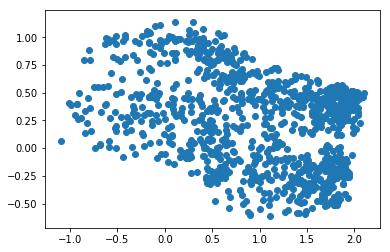

In [57]:
plt.scatter(tt[:,0], tt[:,1])
plt.show()

In [ ]:
pretemperature.assign(math.log(.4)).eval()